# Challenge : envelope detection

The aim of this challenge is to determine what is the best envelope detection algorithm to be used for the [echOpen](http://echopen.org/) probe's raw signal.

This challenge is meant to start playing with usual envelope detection algorithms so as to gather knowledge about state-of-art techniques that could be used in the future to improve the echOpen preprocessing. For more details about the principle of ultrasound imaging and signal processing, you can have a glance at our [gitbook](https://echopen.gitbooks.io/starterkit/content/technical_introduction.html).

In this challenge we'll use raw data that are simulated from images by modulating the signal with a sinusoïdal function, the frequence of which corresponds to the echOpen piezo frequence. Obviously, this is an "ideal" case, but that allows to test different implementations while monitoring the error between the envelope detection algorithm used and the ground truth image from which raw data were simulated.

Eventually, the implementations that will be retained at the end of this challenge will be tested on real echOpen raw data. This will allow to measure the different algorithms' performances in terms of "image quality" (impact on spatial resolution, for example).


## Pipeline

The scheme below sums up the different steps that are gone through in this notebook : 

- Starting from an ultrasound image of good quality ("ground truth"), we apply an amplitude modulation by multiplicating each line by a sinusoidal signal. This allows to simulate what would be the raw signal that would lead to each line in the image.
- We implemented a very basic reconstruction algorithm that will serve as a baseline (i.e. you should do better!). The reconstruction function takes as input the simulated raw signal and performs envelope detection to get an image.
- We compute the error map between the reconstructed image and the ground truth. We attribute to the reconstruction method a score that corresponds to the sum of squared errors between each pixels.
- At the very end of the notebook is a reconstructImage() function in which you can implement your own envelope detection method. Then you'll be able to directly evaluate the score associated with your method. Just play with the reconstructImage() function and try to lower the error!
- Once you're satisfied with your method, you can submit your reconstructImage() to the leaderboard by following the instructions at the end of this notebook.

<img src="files/pipeline.png">

## Loading useful libraries

In [1]:
from __future__ import print_function
import numpy as np
from PIL import Image # for bmp import
from glob import glob
from scipy.misc import imresize
import matplotlib.pyplot as plt
import math
import time

%matplotlib inline

In [44]:
def showImage(imageToPlot):
    plt.figure(figsize=(2, 4))
    plt.gray()
    plt.imshow(imageToPlot.reshape(imageToPlot.shape), aspect='auto')
    plt.show()

def normImag(A):
# Let's normalize the image
    A = A - A.min()
    A = 1.0*A/A.max()
    return(A)

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx],idx

## Loading and studying the 342x719 image of fantom
Here we load the original image that will serve as "ground truth" that we would like to achieve. This image will later be altered in a way that allows to simulate a raw signal (i.e. the image before envelope detection is performed).

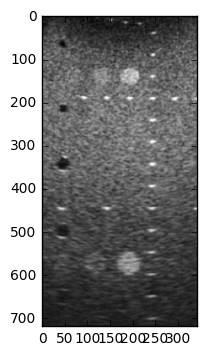

In [3]:
im = Image.open("fantom.bmp").convert('L') # convert 'L' is to get a flat image, not RGB
groundTruth = normImag(np.array(im)) # we use the full [0;1] range
showImage(groundTruth)

Let's assume vertical line points are spaced by 1cm each. This corresponds to a depth of about 13cm.

In [4]:
depth = 0.13 # in meters
resolution = groundTruth.shape[0]/depth # in pts/m
t = depth*2.0/1450.0

print('Image resolution in pixels/mm : ', resolution/1000.0)
print('Listening time in micro-secs : ', t*1.0E6)

Image resolution in pixels/mm :  5.53076923077
Listening time in micro-secs :  179.310344828


The corresponding resolution is 5.53 pts / mm. At a speed of 1450m/s for sound, we'd have a listening time of around 180µs of recording.

## Simulating a raw signal that would lead to this "ground truth" image

Let's assume an ADC sampling rate of 60Msps (close to our prototype) and a piezo frequency f = 3.5 MHz, and compute the length of the raw signal :

In [5]:
sps = 60.0E6
f = 3.5E6
L = int(t*sps)

print("Number of points in raw signal : ", L)

Number of points in raw signal :  10758


The corresponding length of raw signal is close to 11k points.

We can then recreate the raw signal image :

In [6]:
# First create a table of L points for each line, from the original image, by using bicubic interpolation
# This is to get a smoother and more realistic raw signal
BigImg = imresize(groundTruth, ( L,groundTruth.shape[1]), interp='bicubic')

# Then simulate raw signal by modulating the data of BigImg with a sinusoidal function, 
# the frequence of which corresponds to the piezo frequency
rawSignal = np.zeros(shape=(L,groundTruth.shape[1]))
for i in range(len(rawSignal)):
    for j in range(len(rawSignal[0])):
        pixelValue = 1.0*BigImg[i][j]
        w = 2.0*math.radians(180)*f
        rawSignal[i][j] = pixelValue*math.cos(1.0*i*w/sps)

Let's check that we have the image (in green) and the corresponding signal (in blue) :

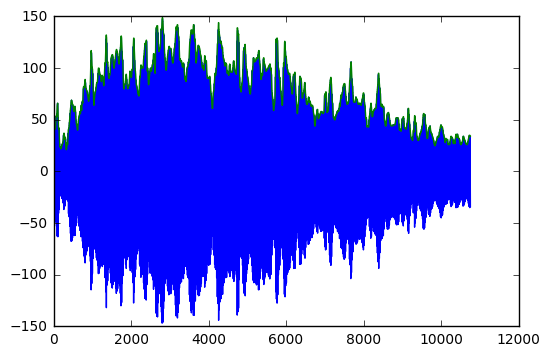

In [7]:
line = np.zeros(shape=(L))
imageLine = np.zeros(shape=(L))
for i in range(len(rawSignal)):
    line[i] =  rawSignal[i][10]
    imageLine[i] = BigImg[i][10]
plt.plot(line)
plt.plot(imageLine)
plt.show()

Let's analyse this signal in the frequency domain, through a FFT. We should see the image, modulated by the 3.5MHz. That is, a "potato" around a 3.5MHz peak :

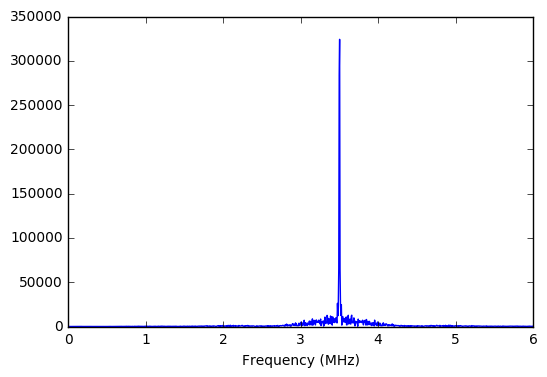

In [8]:
maxFreq = 6.0E6
xLimit = int(L*maxFreq/sps) # upper cap to 
lineFFT = np.abs(np.fft.fft(line))
xScale = range(xLimit)
for i in range(xLimit):
    xScale[i] = (60.0E6)*float(xScale[i])/(L*(1.0E6))
plt.plot(xScale,lineFFT[0:xLimit])
plt.xlabel('Frequency (MHz)')
plt.show()

Conclusion: our rawSignal matches the raw signal's characteristics for the fantom image !

## Saving the raw signal into a file for use in a different code
Let's save the raw signal data into a compressed .csv file so that you'll be able to load it from a different code (e.g. if you're not at ease with python, you can make your own script in whatever language you want to implement the envelope detection algorithm). Note that np.savetxt() and np.load() transparently accepts gz files.

In [9]:
# Let's save the raw signal data
np.savetxt("RawSignal.csv.gz",rawSignal, delimiter=';')

## Envelope detection challenge

Below are the pieces of code related to the proper envelope detection.

- Firstly, some useful functions are defined to display, compare images, and allow performance assessment.
- A basic decimation algorithm is then implemented. This method will serve as a baseline : you're supposed to do better !
- You'll have to define your own envelope detection method
- An automated score estimation and comparison between the baseline and your algorithm are provided.

### Score estimation and comparison functions

The estimateScore() function computes the error map between reconstructed image and the ground truth, and returns a score associated to this error map, as well as the max error achieved on a given pixel.

You should retain the algorithm that achieves the lowest possible value for these scores.

In [10]:
def ssd(A,B):
    A = A - 0.95*A.min()
    A = 1.0*A/A.max()
    B = B - 0.95*B.min()
    B = 1.0*B/B.max()
    squares = (A[:,:] - B[:,:]) ** 2
    return np.sum(squares)

def estimateScore(groundTruth, reconstructedImage) :
    errorMap = (groundTruth - reconstructedImage)
    print('Error map between ground truth and reconstructed image : ')
    showImage(errorMap)
    score = ssd(reconstructedImage,groundTruth)
    maxErr = errorMap.max()
    return [score,maxErr]

def compareImages(im1,im2) :
    plt.figure()
    ax = plt.subplot(1, 2, 1)
    plt.imshow(im1)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(1, 2, 2)
    plt.imshow(im2)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

### Baseline method (don't change this one ! )
This function implements a basic decimation.

In [11]:
def reconstructBaseline(rawSignal,image_shape) :
    reconstructedImage = np.zeros(shape=(image_shape[0],image_shape[1]))
    decimationFactor = 1.0*rawSignal.shape[0]/image_shape[0]

    for i in range(rawSignal.shape[0]):
           for j in range(image_shape[1]): 
                reconstructedImage[int(i/decimationFactor)][j] += np.abs(rawSignal[i][j])
                
    reconstructedImage = normImag(np.abs(reconstructedImage))
    return reconstructedImage

Let's compare the image reconstructed with the baseline method, with the ground truth to achieve : 

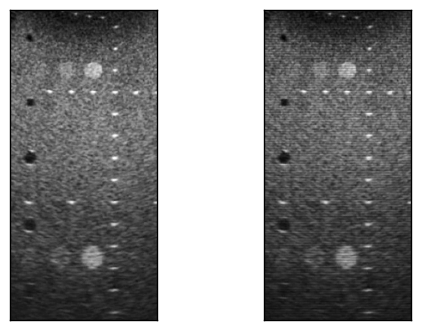

Error map between ground truth and reconstructed image : 


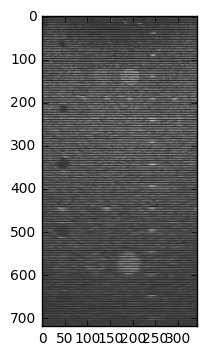

Score for Baseline method :  373.609689815
max Err between pixels for Baseline method :  0.211492444301


In [12]:
reconBaseline = reconstructBaseline(rawSignal,groundTruth.shape)
compareImages(groundTruth, reconBaseline)
[scoreBaseline,maxErrBaseline] = estimateScore(groundTruth, reconBaseline)

print('Score for Baseline method : ', scoreBaseline)
print('max Err between pixels for Baseline method : ', maxErrBaseline)

### Your turn : implement your own method in the function below

In [13]:
def reconstructImage(rawSignal,image_shape) :
    # Here is a copy of the baseline method. Replace that by another method.
    reconstructedImage = np.zeros(shape=(image_shape[0],image_shape[1]))
    decimationFactor = 1.0*rawSignal.shape[0]/image_shape[0]

    for i in range(rawSignal.shape[0]):
           for j in range(image_shape[1]): 
                reconstructedImage[int(i/decimationFactor)][j] += np.abs(rawSignal[i][j])
                
    reconstructedImage = normImag(np.abs(reconstructedImage))
    # The function should return the reconstructed image 
    return reconstructedImage

### Performance assessment of your method

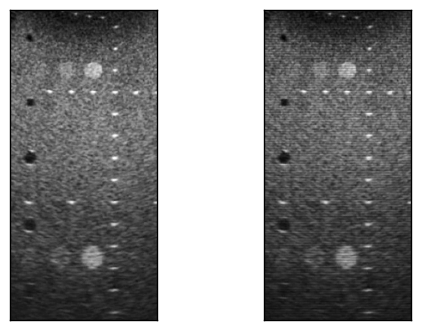

Error map between ground truth and reconstructed image : 


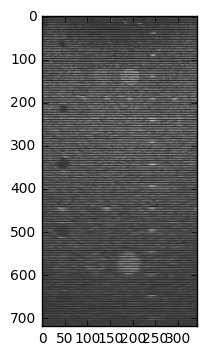

Score for your method :  373.609689815
max Err between pixels for your method :  0.211492444301


In [14]:
recon = reconstructImage(rawSignal,groundTruth.shape)
compareImages(groundTruth, recon)
[score,maxErr] = estimateScore(groundTruth, recon)

print('Score for your method : ', score)
print('max Err between pixels for your method : ', maxErr)

## Submitting your own method to the leaderboard

To submit your own implementation to our leaderboard and compare your performances to other teams, go to http://37.187.117.106:8888/.

- Subscribe to the leaderboard
- Go to the IDE and paste your code, in the same form as the example provided in the cell below. The code should at least include the definition of a function "run(rawSignal,image_shape)" where :
  - rawData is a numpy.array containing the raw signal values (in the same format as in this notebook)
  - imageShape is an array [imageLength, imageWidth] with dimensions of the reconstructed image
  -  the function should return a numpy.array of shape [imageLength, imageWidth] containing the reconstructed image values
- It's possible to install python packages via pip, by defining a "install_packages()" function. The imports should then be done in the run function.
- Click on the "submit" button. 
- After some time, a notification will inform you about your score and your ranking will appear in the leaderboard.

You can submit the example code in the cell below. This implementation should lead to a score of 12481.6872689 


In [15]:
def install_packages():
    import pip
    pip.main(['install', 'scipy'])

def run(rawSignal,image_shape) :
    
    import numpy as np
    from scipy.signal import hilbert

    reconstructedImage = np.zeros(shape=(image_shape[0],image_shape[1]))
    analytic_signal = hilbert(rawSignal)
    amplitude_envelope = np.abs(analytic_signal)
    decimationFactor = 1.0*amplitude_envelope.shape[0]/image_shape[0]
    
    old_pixel = 0
    nb_points=0
    for i in range(amplitude_envelope.shape[0]):
        for j in range(image_shape[1]): 
            reconstructedImage[int(i/decimationFactor)][j] += np.abs(amplitude_envelope[i][j])
        
        if (int(i/decimationFactor) == old_pixel):
            nb_points += 1
        else:
            nb_points += 1
            reconstructedImage[int(i/decimationFactor)-1] = reconstructedImage[int(i/decimationFactor)-1]/nb_points
            nb_points = 1
            old_pixel = old_pixel+1
                
    reconstructedImage = normImag(np.abs(reconstructedImage))
                
    # The function should return the reconstructed image 
    return reconstructedImage

## Test: adding an noise typical for our hardware

We have obtained the typical noise of the device imaging only water (see the  __first characterization__ notebook )

In [46]:
Noise = np.load("../DeviceCaracterization/FirstCharacterization/plate.noise.npz")
f, FFT = Noise["XScale"],Noise["FFT"]
NoisedSignal = np.zeros(xLimit)
for k in range(xLimit):
    Index = find_nearest(f,xScale[k]*1000000)[1]
    NoisedSignal[k] = FFT[Index]

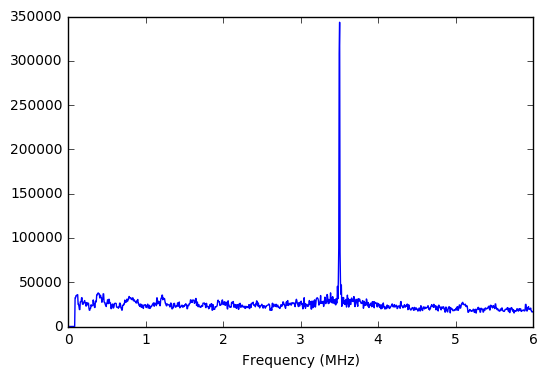

In [59]:
plt.plot(xScale,lineFFT[0:xLimit]+200*NoisedSignal)
plt.xlabel('Frequency (MHz)')
plt.show()

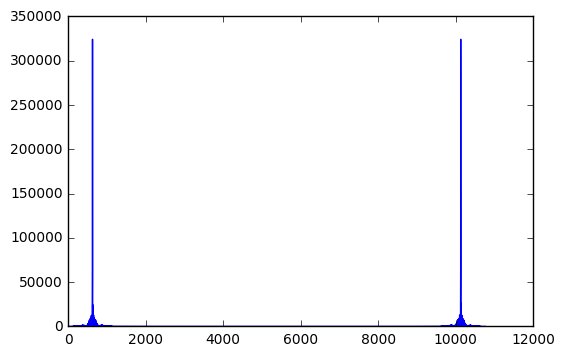

In [60]:
plt.plot(((lineFFT)))
plt.show()